In [18]:
from mnist import MNIST
from matplotlib import pyplot as plot
import numpy as np
import random as random
import pandas as pd
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [3]:
df = pd.read_csv("CSE575-HW03-Data.csv", header=None)
data = df.to_numpy()

In [6]:
def loss(data, clusters):
    total_loss = 0
    
    # Calculate distances and assign points to clusters
    for point in data:
        distances = [np.linalg.norm(cluster["center"] - point) for cluster in clusters.values()]
        cluster_index = np.argmin(distances)
        clusters[list(clusters.keys())[cluster_index]]["points"].append(point)
    
    # Calculate the total loss
    for index, cluster in clusters.items():
        distances_to_center = np.linalg.norm(np.array(cluster["points"]) - cluster["center"], axis=1)
        total_loss += np.sum(distances_to_center ** 2)
    
    return total_loss


In [17]:
k = 2
k_loss = {}
clusters = {}
for i in range(k):
    cluster_center_index = random.randrange(int(i * 128 / k), int((i+1) * 128/ k))
    clusters[i] = {"center": data[cluster_center_index], "points": []}
l = loss(data, clusters)

k_loss[k] = [l]
while True:
    prev_cluster = clusters
    for index in clusters:
        clusters[index]["center"] = np.mean(clusters[index]["points"], axis = 0)
        clusters[index]["points"] = []
    prev_loss = l
    l = loss(data, clusters)
    k_loss[k].append(l)
    if l >= prev_loss :
        clusters = prev_cluster
        break
for k in k_loss:
    l = []
    for i in range(1, len(k_loss[k]) + 1):
        l.append(i)
for index in clusters:
    clusters[index]["cov"] = np.identity(data.shape[1], dtype=np.float64)
    clusters[index]["mu"] = clusters[index]["center"]
    clusters[index]["pi"] = 1.0/k
    del clusters[index]["center"]

print(k_loss[2])

[29098.40468444, 19047.653039327466, 18303.800798926255, 17691.911186443394, 17577.87162366786, 17517.48331925467, 17495.109127996482, 17488.957285790137, 17488.957285790137]


In [8]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [10]:
def mixture(data, clusters):
    totals = np.zeros((data.shape[0], 1), dtype=np.float64)
    for index in clusters:
        pi = clusters[index]["pi"]
        mu = clusters[index]["mu"]
        cov = clusters[index]["cov"]
        gamma = (pi * gaussian(data, mu, cov))
        for i in range(len(data)):
            totals[i] += gamma[i]
        clusters[index]["gamma"] = gamma 
        clusters[index]["totals"] = totals 
    for index in clusters:
        clusters[index]["gamma"] /= clusters[index]["totals"]
    N = float(len(data))
    for index in clusters:
        gamma = clusters[index]["gamma"]
        n = np.sum(gamma, axis = 0)
        pi = n/N
        mu = np.sum(gamma * data, axis = 0) / n
        cov = np.zeros((data.shape[1], data.shape[1]))
        for i in range(len(data)):
            cov += gamma[i] * np.dot((data[i] - mu).reshape(-1, 1), (data[i] - mu).reshape(-1, 1).T)
        cov = cov/n
        clusters[index]["pi"] = pi
        clusters[index]["mu"] = mu
        clusters[index]["cov"] = cov
    totals = []
    for index in clusters:
        totals.append(clusters[index]["totals"])
    totals = np.array(totals)
    l = np.log(totals)
    return np.sum(l), l

In [11]:
def train(data, k, clusters, n_epochs):
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((data.shape[0], k))

    for i in range(n_epochs):
        sum_l, l = mixture(data, clusters)
        likelihoods[i] = sum_l   

In [12]:
n_epochs = 50
train(data, k, clusters, n_epochs)

for index in clusters:
    clusters[index]["center"] = clusters[index]["mu"]
for point in data:
    distances = []
    for index in clusters:
        d = np.sum((clusters[index]["center"] - point) ** 2) ** 0.5
        distances.append(d)
    index = np.argmin(distances)
    clusters[index]["points"].append(point)

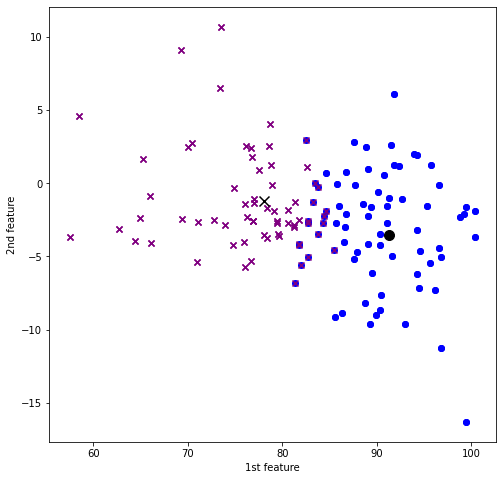

In [13]:
plot.figure(num=None, figsize=(8, 8))
plot.scatter(np.array(clusters[0]["points"])[:,:2][:,0], np.array(clusters[0]["points"])[:,:2][:,1], c="blue", marker='o')
plot.scatter(np.array(clusters[1]["points"])[:,:2][:,0], np.array(clusters[1]["points"])[:,:2][:,1], c="purple", marker='x')
plot.scatter([clusters[0]["center"][:2][0]], [clusters[0]["center"][:2][1]], c="black", marker='.', s = 400, alpha=1)
plot.scatter([clusters[1]["center"][:2][0]], [clusters[1]["center"][:2][1]], c="black", marker='x', s = 100, alpha=1)
plot.xlabel("1st feature")
plot.ylabel("2nd feature")
plot.show()